In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import pickle
import time
from datetime import datetime
from contextlib import contextmanager
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from nltk.corpus import stopwords
from tqdm import tqdm
import re

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,Conv1D,concatenate,LSTM,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,Flatten,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [0]:
os.chdir('/content/drive/My Drive/Case Study I')

In [0]:
file = open('X_train_tfidf','rb')
X_train_tfidf = pickle.load(file)
file.close()

file = open('X_test_tfidf','rb')
X_test_tfidf = pickle.load(file)
file.close()

file = open('y_train_tfidf','rb')
y_train_tfidf = pickle.load(file)
file.close()

file = open('y_test_tfidf','rb')
y_test_tfidf = pickle.load(file)
file.close()

In [4]:
print("X_train TFIDF Shape : ",X_train_tfidf.shape)
print("y_train TFIDF Shape : ",y_train_tfidf.shape)
print("X_test TFIDF Shape : ",X_test_tfidf.shape)
print("y_test TFIDF Shape : ",y_test_tfidf.shape)

X_train TFIDF Shape :  (1111239, 136019)
y_train TFIDF Shape :  (1111239,)
X_test TFIDF Shape :  (370634, 136019)
y_test TFIDF Shape :  (370634,)


In [0]:
# Reference : https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064

def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

# Defining Models

In [0]:
# Reference : https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [7]:
# Reference : https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
# The Model architecture is inspired from the above link

# Defining Input Layer

import keras.backend as K
K.clear_session()

input_layer = Input(shape=(X_train_tfidf.shape[1],), dtype='float32', sparse=True)

layer1 = Dense(256,activation = "relu",
               kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(input_layer)

layer2 = Dense(64,activation = "relu",
               kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer1)

layer3 = Dense(64,activation = "relu",
               kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer2)

layer4 = Dense(32,activation = "relu",
               kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer3)

output_layer = Dense(1,kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer4)

model = Model(inputs = input_layer, outputs = output_layer)

model.summary()

Using TensorFlow backend.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 136019)]          0         
_________________________________________________________________
dense (Dense)                (None, 256)               34821120  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 34,843,841
Trainable params: 34,843,841
Non-trainable params: 0
_________________________________________________

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

model.compile(optimizer=optimizer,loss = "mean_squared_error")

for i in range(4):
  with timer(f'epoch {i + 1}'):
    model.fit(X_train_tfidf,y_train_tfidf,batch_size=2**(8 + i),epochs=1,verbose=1,
            validation_data = (X_test_tfidf,y_test_tfidf))
    
    y_pred = np.expm1(model.predict(X_test_tfidf)[:,0])
    print("Test RMSLE for Batch Size : ", 2**(8 + i), " is : ", rmsle_score(np.expm1(y_test_tfidf),y_pred))
  


4341/4341 [==============================] - 64s 15ms/step - loss: 0.2341 - val_loss: 0.1973
Test RMSLE for Batch Size :  256  is :  0.4441428350976804
[epoch 1] done in 84 s
2171/2171 [==============================] - 37s 17ms/step - loss: 0.1489 - val_loss: 0.1913
Test RMSLE for Batch Size :  512  is :  0.4373425273347995
[epoch 2] done in 56 s
1086/1086 [==============================] - 23s 21ms/step - loss: 0.0920 - val_loss: 0.1973
Test RMSLE for Batch Size :  1024  is :  0.44414521466676715
[epoch 3] done in 41 s
543/543 [==============================] - 15s 28ms/step - loss: 0.0517 - val_loss: 0.2019
Test RMSLE for Batch Size :  2048  is :  0.44929108285637764
[epoch 4] done in 34 s


Model Performs Better when Batch Size is equal to 512 with Test RMSLE Score of 0.4373<br/>
Also to Note is that the Model starts Overfitting after 2 epochs.

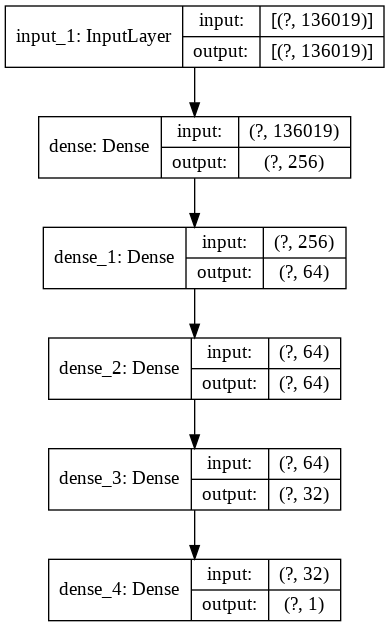

In [9]:
tf.keras.utils.plot_model(model,to_file='model_mlp1.png',show_shapes=True,show_layer_names=True)

### Standardizing the Price Column

In [0]:
# Standardizing the Log Price Value before feeding it to MLP
standardscaler = StandardScaler()
y_train = standardscaler.fit_transform(y_train_tfidf.reshape(-1,1))
y_test = standardscaler.transform(y_test_tfidf.reshape(-1,1))

In [11]:
tf.keras.backend.clear_session()

input_layer = Input(shape=(X_train_tfidf.shape[1],), dtype='float32', sparse=True)

layer1 = Dense(256,activation = "relu",
               kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(input_layer)

layer2 = Dense(64,activation = "relu",
               kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer1)

layer3 = Dense(64,activation = "relu",
               kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer2)

layer4 = Dense(32,activation = "relu",
               kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer3)

output_layer = Dense(1,kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer4)

model1 = Model(inputs = input_layer, outputs = output_layer)

model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 136019)]          0         
_________________________________________________________________
dense (Dense)                (None, 256)               34821120  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 34,843,841
Trainable params: 34,843,841
Non-trainable params: 0
_________________________________________________

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

model1.compile(optimizer=optimizer,loss = "mean_squared_error")

for i in range(3):
  with timer(f'epoch {i + 1}'):
    model1.fit(X_train_tfidf,y_train,batch_size=2**(8 + i),epochs=1,verbose=1,
            validation_data = (X_test_tfidf,y_test))
    
    y_pred = model1.predict(X_test_tfidf)[:,0]
    y_pred = np.expm1(standardscaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
    y_test_temp = np.expm1(standardscaler.inverse_transform(y_test.reshape(-1, 1)))
    print("Test RMSLE for Batch Size : ", 2**(8 + i), " is : ", rmsle_score(y_test_temp,y_pred))

4341/4341 [==============================] - 66s 15ms/step - loss: 0.3755 - val_loss: 0.3427
Test RMSLE for Batch Size :  256  is :  0.436586944361543
[epoch 1] done in 86 s
2171/2171 [==============================] - 37s 17ms/step - loss: 0.2357 - val_loss: 0.3326
Test RMSLE for Batch Size :  512  is :  0.43010334588538324
[epoch 2] done in 57 s
1086/1086 [==============================] - 23s 21ms/step - loss: 0.1349 - val_loss: 0.3409
Test RMSLE for Batch Size :  1024  is :  0.4353989067121929
[epoch 3] done in 43 s


We can see that with standardization, Model Performs Better when Batch Size is 512 with Test RMSLE = 0.4301

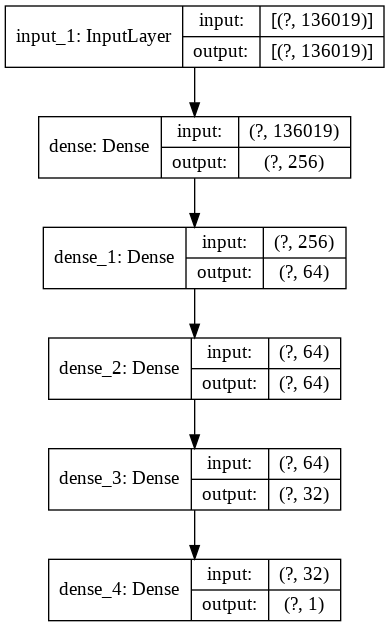

In [13]:
tf.keras.utils.plot_model(model1,to_file='model_mlp1.png',show_shapes=True,show_layer_names=True)

# LSTM Model

In [0]:
# Reference : https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
data = pd.read_csv('train.tsv',sep='\t')
data = data[(data.price >= 3) & (data.price <= 2000)].reset_index(drop=True)

cv = KFold(n_splits=20, shuffle=True, random_state=42)
train_ids, test_ids = next(cv.split(data))
# The above two line of code does K Fold Train Test Splitting where the Entire data 
# is divided into 20 folds each of size = len(data) // fold_size.
# Here data is roughly 1.4M and fold is 20 so each fold would be approx 74K

train, test = data.iloc[train_ids], data.iloc[test_ids]
# The Id's are saved to train and test respectively

# As we have seen that taking log values of the Price Column and
# standardizing them gives good result we will do the same

scaler = StandardScaler()
train_price = train['price'].values.reshape(-1,1)
test_price = test['price'].values.reshape(-1,1)

y_train = scaler.fit_transform(np.log1p(train_price))
y_test = scaler.transform(np.log1p(test_price))

print("X_Train Data Shape : ",train.shape)
print("y_train Shape : ",y_train.shape)
print("X_Test Data Shape : ",test.shape)
print("y_test Shape : ",y_test.shape)

X_Train Data Shape :  (1407575, 8)
y_train Shape :  (1407575, 1)
X_Test Data Shape :  (74083, 8)
y_test Shape :  (74083, 1)


In [0]:
# Reference : Applied AI Course
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)

  return phrase

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stop_words = stopwords.words('english')
def preprocessing_text(text):
  preprocessed_text = []
  for sentence in tqdm(text.values):
    sentence = decontracted(sentence)
    sent = sentence.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e not in stop_words)
    preprocessed_text.append(sent.lower().strip())
  return preprocessed_text

In [0]:
# Reference : https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
# The above reference suggests to combine name and brand_name, description,name and category name
# so as to have only 4 columns apart from the proce column

def new_preprocess(df):
  df['name'] = df['preprocess_name'].fillna('') + ' ' + df['brand_name'].fillna('')
  df['text'] = (df['preprocess_desc'].fillna('') + ' ' + df['preprocess_name'] + ' ' + df['category_name'].fillna(''))

  return df[['name', 'text', 'shipping', 'item_condition_id']]

In [0]:
train['name'] = train['name'].replace([np.nan], '')
test['name'] = test['name'].replace([np.nan], '')

train['item_description'] = train['item_description'].replace([np.nan], '')
test['item_description'] = test['item_description'].replace([np.nan], '')

In [0]:
train['preprocess_name'] = preprocessing_text(train['name'])
test['preprocess_name'] = preprocessing_text(test['name'])

train['preprocess_desc'] = preprocessing_text(train['item_description'])
test['preprocess_desc'] = preprocessing_text(test['item_description'])

100%|██████████| 74083/74083 [00:04<00:00, 16040.58it/s]


In [0]:
X_train = new_preprocess(train)
X_test = new_preprocess(test)
print(X_train.shape)
print(X_test.shape)

(1407575, 4)
(74083, 4)


In [0]:
X_train.columns

Index(['name', 'text', 'shipping', 'item_condition_id'], dtype='object')

## Tokenizing Name and Text Columns

In [0]:
tokenizer_obj = Tokenizer(oov_token="UNK")
tokenizer_obj.fit_on_texts(X_train["name"])
print("Vocab Size : ", len(tokenizer_obj.word_index) + 1)

Vocab Size :  102351


In [0]:
s = X_train.name.values
name_length = []
for i in range(len(s)):
  name_length.append(len(s[i]))

print(len(name_length))

1407575


In [0]:
name_length.sort() # Sorting the name length in ascending order
numpy_array = np.asarray(name_length)

In [0]:
for i in range(1,11):
  percentile_value = int(np.percentile(numpy_array,i*10))
  print(i*10,"th Percentile Value : ", percentile_value)

10 th Percentile Value :  17
20 th Percentile Value :  21
30 th Percentile Value :  25
40 th Percentile Value :  28
50 th Percentile Value :  31
60 th Percentile Value :  34
70 th Percentile Value :  37
80 th Percentile Value :  40
90 th Percentile Value :  45
100 th Percentile Value :  79


In [0]:
for i in range(1,10):
  percentile_value = int(np.percentile(numpy_array,90 + i))
  print(90 + i,"th Percentile Value : ", percentile_value)

91 th Percentile Value :  46
92 th Percentile Value :  46
93 th Percentile Value :  47
94 th Percentile Value :  48
95 th Percentile Value :  49
96 th Percentile Value :  50
97 th Percentile Value :  51
98 th Percentile Value :  53
99 th Percentile Value :  55


Since 99 percentile of the Name are of length 55 we will have name to of length 55

In [0]:
max_name_length = 55
X_train_name = tokenizer_obj.texts_to_sequences(X_train["name"])
X_test_name = tokenizer_obj.texts_to_sequences(X_test["name"])

In [0]:
X_train_name_pad = np.asarray(pad_sequences(X_train_name,maxlen = max_name_length,padding = 'post'),
                         dtype = np.float)
X_test_name_pad = np.asarray(pad_sequences(X_test_name,maxlen = max_name_length,padding = 'post'),
                         dtype = np.float)

print(X_train_name_pad.shape)
print(X_test_name_pad.shape)

(1407575, 55)
(74083, 55)


In [0]:
from numpy import asarray

embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

print(len(embeddings_index["the"]))

Loaded 400000 word vectors.
100


In [0]:
vocab_size = len(tokenizer_obj.word_index) + 1

name_embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer_obj.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    name_embedding_matrix[i] = embedding_vector

In [0]:
print("Name Embedding Matrix Size : ", name_embedding_matrix.shape)

Name Embedding Matrix Size :  (102351, 100)


In [0]:
name_embedding_layer = Embedding(vocab_size,100, weights = [name_embedding_matrix],
                                 input_length = max_name_length, trainable = False)

In [0]:
tokenizer_obj = Tokenizer(oov_token="UNK")
tokenizer_obj.fit_on_texts(X_train["text"])
print("Vocab Size : ", len(tokenizer_obj.word_index) + 1)

Vocab Size :  196636


In [0]:
s = X_train.text.values
text_length = []
for i in range(len(s)):
  text_length.append(len(s[i]))

print(len(text_length))

1407575


In [0]:
text_length.sort() # Sorting the text length in ascending order
numpy_array = np.asarray(text_length)

In [0]:
for i in range(1,11):
  percentile_value = int(np.percentile(numpy_array,i*10))
  print(i*10,"th Percentile Value : ", percentile_value)

10 th Percentile Value :  68
20 th Percentile Value :  82
30 th Percentile Value :  95
40 th Percentile Value :  110
50 th Percentile Value :  127
60 th Percentile Value :  148
70 th Percentile Value :  176
80 th Percentile Value :  223
90 th Percentile Value :  330
100 th Percentile Value :  1050


In [0]:
for i in range(1,10):
  percentile_value = int(np.percentile(numpy_array,90 + i))
  print(90 + i,"th Percentile Value : ", percentile_value)

91 th Percentile Value :  350
92 th Percentile Value :  372
93 th Percentile Value :  399
94 th Percentile Value :  431
95 th Percentile Value :  469
96 th Percentile Value :  517
97 th Percentile Value :  584
98 th Percentile Value :  673
99 th Percentile Value :  775


In [0]:
for i in range(1,10):
  percentile_value = int(np.percentile(numpy_array,99 + i*0.1))
  print(99 + i*0.1,"th Percentile Value : ", percentile_value)

99.1 th Percentile Value :  787
99.2 th Percentile Value :  799
99.3 th Percentile Value :  810
99.4 th Percentile Value :  823
99.5 th Percentile Value :  837
99.6 th Percentile Value :  852
99.7 th Percentile Value :  868
99.8 th Percentile Value :  890
99.9 th Percentile Value :  920


Since 90 percentile of text is of length less than or equal to 330 our text would be of 330 length

In [0]:
max_text_length = 330
X_train_text = tokenizer_obj.texts_to_sequences(X_train["text"])
X_test_text = tokenizer_obj.texts_to_sequences(X_test["text"])

In [0]:
X_train_text_pad = np.asarray(pad_sequences(X_train_text,maxlen = max_text_length,padding = 'post'),
                         dtype = np.float)
X_test_text_pad = np.asarray(pad_sequences(X_test_text,maxlen = max_text_length,padding = 'post'),
                         dtype = np.float)

print(X_train_text_pad.shape)
print(X_test_text_pad.shape)

(1407575, 330)
(74083, 330)


In [0]:
vocab_size = len(tokenizer_obj.word_index) + 1

text_embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer_obj.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    text_embedding_matrix[i] = embedding_vector

In [0]:
print("Text Embedding Matrix Size : ", text_embedding_matrix.shape)

Text Embedding Matrix Size :  (196636, 100)


In [0]:
text_embedding_layer = Embedding(vocab_size,100, weights = [text_embedding_matrix],
                                 input_length = max_text_length, trainable = False)

In [0]:
tf.keras.backend.clear_session()

Input_layer_name = Input(shape = (max_name_length,), name = "Input_Layer_for_Name")
Input_layer_text = Input(shape = (max_text_length,), name = "Input_Layer_for_text")
Input_layer_item_cond = Input(shape = (1,), name = "Input_for_Item_Cond")
Input_layer_ship = Input(shape=(1,), name = "Input_for_Shipping")

Embedding_layer_name = name_embedding_layer(Input_layer_name)

Embedding_layer_text = text_embedding_layer(Input_layer_text)

lstm_layer_name = LSTM(32, return_sequences=True, recurrent_dropout=0.3)(Embedding_layer_name)

lstm_layer_text = LSTM(32, return_sequences=True, recurrent_dropout=0.3)(Embedding_layer_text)

flatten_1 = Flatten()(lstm_layer_name)

flatten_2 = Flatten()(lstm_layer_text)

concate_layer = concatenate([flatten_1,flatten_2,Input_layer_item_cond,Input_layer_ship],name = "concat")

print("After Concatenation : ", concate_layer.shape)

layer1 = Dense(64,activation="relu")(concate_layer)

layer2 = Dense(32,activation="relu")(layer1)

batch_norm = BatchNormalization()(layer2)

layer3 = Dense(16,activation="relu")(batch_norm)

output_layer = Dense(1)(layer3)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

model = Model(inputs = [Input_layer_name,Input_layer_text,
                        Input_layer_item_cond,Input_layer_ship],
              outputs = output_layer)

model.compile(optimizer = optimizer, loss = "mean_squared_error")

model.summary()

After Concatenation :  (None, 12322)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer_for_Name (InputLaye [(None, 55)]         0                                            
__________________________________________________________________________________________________
Input_Layer_for_text (InputLaye [(None, 330)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 100)      10235100    Input_Layer_for_Name[0][0]       
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 330, 100)     19663600    Input_Layer_for_text[0][0]       
_________________________________________________________

In [0]:
inputs = [X_train_name_pad,X_train_text_pad,X_train['item_condition_id'].values,
          X_train['shipping'].values]

test_data = [X_test_name_pad,X_test_text_pad,X_test['item_condition_id'].values,
          X_test['shipping'].values]

for i in range(1):
  with timer(f'epoch {i + 1}'):
    model.fit(inputs,y_train,batch_size=2**(9 + i),epochs=1,verbose=1,
            validation_data = (test_data,y_test))
    y_pred = model.predict(test_data)[:,0]
    y_pred = np.expm1(scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
    print("Test RMSLE for Batch Size : ", 2**(9 + i), " is : ", rmsle_score(test_price,y_pred))

2750/2750 [==============================] - 2852s 1s/step - loss: 0.4809 - val_loss: 0.4211
Test RMSLE for Batch Size :  512  is :  0.4839663736319845
[epoch 1] done in 3096 s


Since Training LSTM takes Time(> 1 hrs) and it also shoots over the RAM usage, I have trained it only for 1 epochs resulting in Test RMSLE 0.484

In [14]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Test RMSLE"]

x.add_row(["Sparse MLP without Standardization ",0.4373])

x.add_row(["Sparse MLP with Standardization ",0.4301])

x.add_row(["LSTM ",0.484])

print(x)

+-------------------------------------+------------+
|                Model                | Test RMSLE |
+-------------------------------------+------------+
| Sparse MLP without Standardization  |   0.4373   |
|   Sparse MLP with Standardization   |   0.4301   |
|                LSTM                 |   0.484    |
+-------------------------------------+------------+


From the above Table "Sparse MLP with Target Column Standardized" performs better than other Models